# implement methods using fake data

- [Jakub] Classify edges of the boundary as marker + or -.
- [Jakub] Get immune cells from inside the tumor environment (parameterized by distance from tumor edge). These predictions will be at 25 micrometers at the moment. So environment for now can be N*25 micrometers, where N is an integer >= 1.
- [Jakub] Get distance from each pixel in each cell to the nearest M+ boundary and M- boundary. The distance to the nearest boundary can be in a different tumor microenvironment.

# create fake tumor data and M+/- data

In [1]:
import random

import matplotlib.pyplot as plt
from shapely.geometry import box, Point, Polygon
import shapely.ops

In [2]:
tumor_grid = 25  # micrometers
x0, y0 = 10_000, 20_000
ncols, nrows = 10, 10

In [3]:
random.seed(42)
labels = []
for col in range(ncols):
    for row in range(nrows):
        x = col * tumor_grid + x0
        y = row * tumor_grid + y0
        c = dict(minx=x, miny=y, maxx=x+tumor_grid, maxy=y+tumor_grid)
        klass = random.choices(["tumor", "non-tumor", "blank"], weights=[0.3, 0.6, 0.1])[0]
        k17status = None
        if klass == "tumor":
            k17status = random.choices(["+", "-"], weights=[0.3, 0.7])[0]
        labels.append({"coordinates": c, "class": klass, "k17status": k17status})

In [4]:
for label in labels:
    label["polygon"] = box(**label["coordinates"])

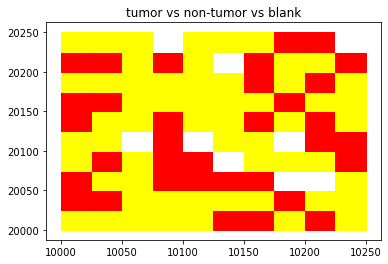

In [5]:
colors = {"tumor": "red", "non-tumor": "yellow", "blank": "white"}
for label in labels:
    plt.fill(*label["polygon"].exterior.xy, color=colors[label["class"]])
plt.title("tumor vs non-tumor vs blank")
plt.show()

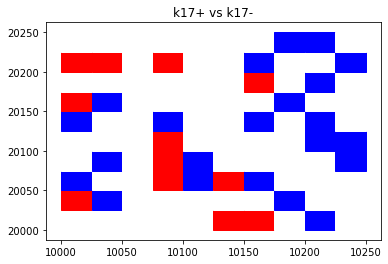

In [6]:
colors = {"+": "red", "-": "blue", None: "white"}
for label in labels:
    plt.fill(*label["polygon"].exterior.xy, color=colors[label["k17status"]])
plt.title("k17+ vs k17-")
plt.show()

# find closest M+ and M- boundaries to a point

In [7]:
all_tumor_polygons = [label["polygon"] for label in labels if label["class"] == "tumor"]

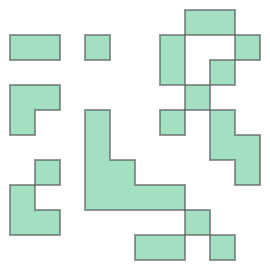

In [8]:
tumor = shapely.ops.unary_union(all_tumor_polygons)
tumor

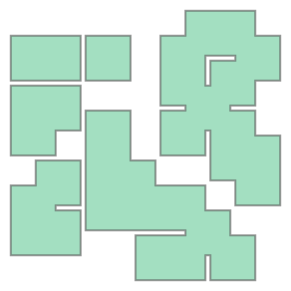

In [9]:
# TODO: see https://shapely.readthedocs.io/en/stable/manual.html#prepared.prep
#   when checking if points are contained in the microenvironment. 
# Use this to get tumor microenvironment at different distances...
tumor.buffer(10, join_style=shapely.geometry.JOIN_STYLE.mitre)

In [10]:
all_mpos_polygons = [label["polygon"] for label in labels if label["k17status"] == "+"]
all_mneg_polygons = [label["polygon"] for label in labels if label["k17status"] == "-"]

mpos = shapely.ops.unary_union(all_mpos_polygons)
mneg = shapely.ops.unary_union(all_mneg_polygons)

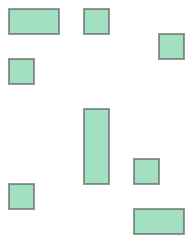

In [11]:
mpos

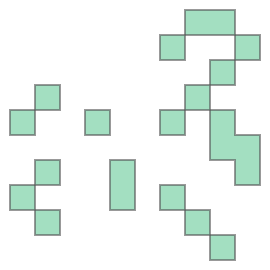

In [12]:
mneg

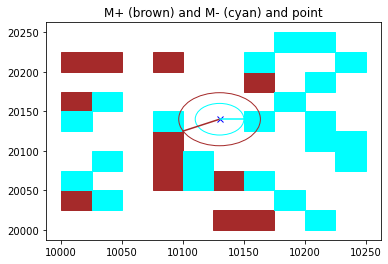

In [13]:
p = Point(10130, 20140)

# M+ squares
for geom in mpos.geoms:
    plt.fill(*geom.exterior.xy, color="brown")
# M- squares
for geom in mneg.geoms:
    plt.fill(*geom.exterior.xy, color="cyan")

# pixel of the cell we're interested in
plt.plot(p.x, p.y, "bx")

# circles to closest M+ and M- squares
circle_to_mpos = plt.Circle((p.x, p.y), radius=p.distance(mpos), color="brown", fill=False)
circle_to_mneg = plt.Circle((p.x, p.y), radius=p.distance(mneg), color="cyan", fill=False)
plt.gca().add_patch(circle_to_mpos)
plt.gca().add_patch(circle_to_mneg)

# lines to closest M+ and M- squares
p_to_mpos1, p_to_mpos2 = shapely.ops.nearest_points(p, mpos)
p_to_mneg1, p_to_mneg2 = shapely.ops.nearest_points(p, mneg)
plt.plot((p_to_mpos1.x, p_to_mpos2.x), (p_to_mpos1.y, p_to_mpos2.y), color="brown")
plt.plot((p_to_mneg1.x, p_to_mneg2.x), (p_to_mneg1.y, p_to_mneg2.y), color="cyan")

plt.title("M+ (brown) and M- (cyan) and point")
plt.show()

# scratch pad...

In [14]:
shapely.geometry.base.BaseGeometry

shapely.geometry.base.BaseGeometry

In [15]:
geom.bounds

(10150.0, 20200.0, 10175.0, 20225.0)

In [16]:
def geom_to_points(geom):
    # convert values to int
    xmin, ymin, xmax, ymax = map(round, geom.bounds)
    coords = itertools.product(range(xmin, xmax+1), range(ymin, ymax+1))
    points = (Point(*p) for p in coords)
    points = MultiPoint(points).intersection(geom)
    return points

In [17]:
import numpy as np

In [18]:
t = tumor.geoms[1]

In [19]:
# convert these things to integers
xmin, ymin, xmax, ymax = map(round, t.bounds)

In [20]:
x = np.arange(xmin, xmax+1, dtype="int32")
y = np.arange(ymin, ymax+1, dtype="int32")

In [21]:
import itertools

In [22]:
itertools.product(range(xmin, xmax+1), range(ymin, ymax+1))

In [23]:
points = [Point(*p) for p in itertools.product(range(xmin, xmax+1), range(ymin, ymax+1))]

In [24]:
points = shapely.geometry.MultiPoint(points).intersection(t)

In [25]:
type(points)

shapely.geometry.multipoint.MultiPoint

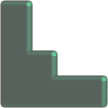

In [26]:
points

In [27]:
points.geoms[0].bounds

(10075.0, 20050.0, 10075.0, 20050.0)